In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from rdkit import Chem # recorda que hay un ambiente con estas librerias

# Modelo CNN con generador, embedings de smiles y data-augmentation

In [3]:
import pandas as pd
import numpy as np
from datagen import smiles_dict, smiles_to_seq

### smiles_dict

In [4]:
len(smiles_dict)

42

smiles_dict nos da un tokenizador para simplificar el problema. Puede ver como se construyó en la notebook **deep_chem**.
Si al momento de correr el modelo con este diccionario encuentra problemas de key_error, puede agregar los faltantes al diccionario

Mirar dentro de **datagen.py** como se usa este diccionario con la función **smiles_to_seq** para tokenizar. El código es muy sencillo

In [5]:
print(smiles_dict)

{'#': 1, '(': 2, ')': 3, '+': 4, '-': 5, '/': 6, '1': 7, '2': 8, '3': 9, '4': 10, '5': 11, '6': 12, '7': 13, '8': 14, '=': 15, 'C': 16, 'F': 17, 'H': 18, 'I': 19, 'N': 20, 'O': 21, 'P': 22, 'S': 23, '[': 24, '\\': 25, ']': 26, '_': 27, 'c': 28, 'Cl': 29, 'Br': 30, 'n': 31, 'o': 32, 's': 33, '@': 34, '.': 35, 'a': 36, 'B': 37, 'e': 38, 'i': 39, '9': 40, '10': 41, '11': 42}


# Carga de los datos

In [6]:
df = pd.read_csv('data/acetylcholinesterase_02_bioactivity_data_preprocessed.csv')

In [7]:
max_len_idx = df['canonical_smiles'].apply(len).argmax()
min_len_idx = df['canonical_smiles'].apply(len).argmin()
max_sequence_len = len(df['canonical_smiles'].iloc[max_len_idx]) + 20

In [247]:
len(df['canonical_smiles'].iloc[max_len_idx]),max_sequence_len

(207, 227)

In [248]:
df['canonical_smiles'][max_len_idx]

'C[C@@]12CC[C@H]3[C@]4(C)CCC[C@@]5(C)C(=O)OCC[N+](C)(C)CCCCCCCCC[N+](C)(C)CCOC(=O)[C@]6(C)CCC[C@]7(C)[C@@H]6CC[C@@]68C[C@@H](OC(=O)CCCCCCCCC(=O)O[C@@H]1C[C@@]3(CC[C@@H]45)C2)[C@@](C)(CC[C@@H]76)C8.[Br-].[Br-]'

In [8]:
df.head()

,molecule_chembl_id,canonical_smiles,standard_value,standard_value_norm,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,750.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,100.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,50000.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,300.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,800.0,6.096910


In [13]:
X = df['canonical_smiles'].values
y = df['pIC50'].values

# Data augmentation:

https://arxiv.org/pdf/1703.07076.pdf

https://github.com/EBjerrum/molvecgen

https://github.com/Ebjerrum/SMILES-enumeration

En la publicación de arriba se describe una técnica de aumentación de datos para los smiles. Leerla si es de su interes (Opcional)

En el módulo **dataug.py**, tomando como referencia los repositorios arriba citados se implementó la aumentación de datos

In [9]:
from dataaug import SmilesEnumerator
sme = SmilesEnumerator()
for i in range(5):
    print(sme.randomize_smiles('CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1'))
    

c1c(-n2c(=O)oc(OCC)n2)cccc1OCc1ccccc1
c1cc(COc2cccc(-n3c(=O)oc(OCC)n3)c2)ccc1
c1c(COc2cc(-n3nc(OCC)oc3=O)ccc2)cccc1
c1ccc(COc2cccc(-n3c(=O)oc(OCC)n3)c2)cc1
c1c(COc2cc(-n3nc(OCC)oc3=O)ccc2)cccc1


In [260]:
sme.randomize_smiles(X[1])

'c1cc(-c2nc(SCC3CC3)n(C(=O)N3CCCCC3)n2)ccc1Cl'

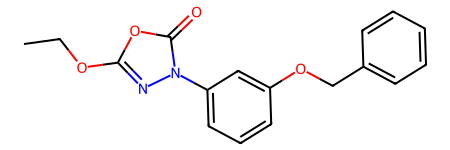

In [10]:
m1 = Chem.MolFromSmiles('CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1')
m1

# DataGenerator

Construir un generador al que se le pase al instanciarlo:
- X: smiles (formula química)
- y: pIC50
- batch_size
- max_sequence_len (int): La máxima longitud de las secuencias (para hacer el padding)
- data_augmentation (boolean): si quiero hacer o no data-augmentation. 
- shuffle (boolean)

Guardarlo en el módulo **datagen.py** con el nombre de la clase **DataGenerator**

Notar que el módulo **datagen.py** ya tiene una estructura para completar

### Importamos el módulo y lo probamos

In [11]:
from datagen import DataGenerator

In [14]:
dgen = DataGenerator(X, y, max_sequence_len, batch_size=16)

In [16]:
len(dgen)* dgen.batch_size

5824

In [17]:
for i, (X_b, y_b) in enumerate(dgen):
    print(f'{i}\r', end='')

# Split

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
len(X_train), len(y_train), len(X_test)

(4659, 4659, 1165)

In [21]:
X_train

array(['COc1cc2c(cc1O)CCC(C)(CC(=O)NCCCCCCCCNc1c3c(nc4ccccc14)CCCC3)O2',
       'O=C(NC1CCN(Cc2ccc(F)cc2)CC1)c1cncc(NC(=O)c2ccnc3[nH]ccc23)c1',
       'N#Cc1cc2c(cn1)[nH]c1ncc(-c3ccc(CN4CCC[C@@H](O)C4)cc3)cc12', ...,
       'C(=N\\C1CCN(Cc2ccccc2)C1)\\c1ccccc1',
       'COc1cc2c(cc1O)CCC(C)(CCNCCCCCCCCNc1c3c(nc4cc(Cl)ccc14)CCCC3)O2',
       'CN(C)Cc1ccc(CSCCCCCCCCSCc2ccc(CN(C)C)o2)o1'], dtype=object)

In [22]:
dgen_train = DataGenerator(X_train, y_train, seq_length=max_sequence_len, batch_size=128, data_augmentation=True)
dgen_test = DataGenerator(X_test, y_test, seq_length=max_sequence_len, batch_size=128, data_augmentation=False)

In [23]:
len(dgen_train), len(dgen_test)

(37, 10)

In [282]:
X_train[1:3]

array(['O=C(NC1CCN(Cc2ccc(F)cc2)CC1)c1cncc(NC(=O)c2ccnc3[nH]ccc23)c1',
       'N#Cc1cc2c(cn1)[nH]c1ncc(-c3ccc(CN4CCC[C@@H](O)C4)cc3)cc12'],
      dtype=object)

In [307]:
dgen_train11 = DataGenerator(X_train[0:3], y_train[0:3], seq_length=max_sequence_len, batch_size=3, data_augmentation=True)


In [308]:
dgen_train11[0]

(array([[28,  7,  8, 28,  2, 28,  2, 16,  2, 20, 28,  9, 28, 28,  2, 16,
          2, 15, 21,  3, 20, 16, 10, 16, 16, 20,  2, 16, 28, 11, 28, 28,
         28,  2, 17,  3, 28, 28, 11,  3, 16, 16, 10,  3, 28, 31, 28,  9,
          3, 15, 21,  3, 28, 28, 31,  7,  3, 28, 28, 24, 31, 18, 26,  8,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0

In [271]:
for i, (X_b, y_b) in enumerate(dgen_test):
    print(f'{i}\r', end='')

In [25]:
X_b.shape

(13, 227)

# Network Model

In [26]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout, Activation, BatchNormalization, Conv1D, MaxPool1D, GlobalAveragePooling1D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras import layers as L

In [43]:
def text_cnn_1d(sequence_length, vocab_size, embedding_size, filter_sizes, num_filters):
    max_pool_div = 4
    input_x = L.Input(shape=(sequence_length,), name='input_x')
    embedding = L.Embedding(vocab_size + 1, embedding_size, name='embedding')(input_x)
    pooled_outputs = []
    for filter_size in filter_sizes:
        conv = L.Conv1D(filters=num_filters, kernel_size=filter_size, padding='same', dilation_rate=1, activation='relu')(embedding)
        max_p = L.MaxPool1D(128)(conv)
        pooled_outputs.append(max_p)
    h_pool = L.Concatenate(axis=2)(pooled_outputs)
    dense = L.Flatten()(h_pool)
    dense = L.Dense(100, activation='relu')(dense)
    dense = L.Dense(100, activation='relu')(dense)
    dense = L.Dense(1)(dense)
    model = tf.keras.models.Model(input_x, dense)
    return model

def text_cnn_1d_modif(sequence_length, vocab_size, embedding_size, filter_sizes, num_filters):
    max_pool_div = 4
    input_x = L.Input(shape=(sequence_length,), name='input_x')
    embedding = L.Embedding(vocab_size + 1, embedding_size, name='embedding')(input_x)
    pooled_outputs = []
    for filter_size in filter_sizes:
        conv = L.Conv1D(filters=num_filters, kernel_size=filter_size, padding='same', dilation_rate=1, activation='relu')(embedding)
        max_p = L.MaxPool1D((sequence_length - filter_size + 1)//max_pool_div)(conv)
        pooled_outputs.append(max_p)
        
        conv = L.Conv1D(filters=num_filters, kernel_size=filter_size, padding='same', dilation_rate=2, activation='relu')(embedding)
        max_p = L.MaxPool1D((sequence_length - filter_size + 1)//max_pool_div)(conv)
        pooled_outputs.append(max_p)
        
        conv = L.Conv1D(filters=num_filters, kernel_size=filter_size, padding='same', dilation_rate=3, activation='relu')(embedding)
        max_p = L.MaxPool1D((sequence_length - filter_size + 1)//max_pool_div)(conv)
        pooled_outputs.append(max_p)
    h_pool = L.Concatenate(axis=2)(pooled_outputs)
    dense = L.Flatten()(h_pool)
    dense = L.Dense(50, activation='relu')(dense)
    dense = L.Dense(50, activation='relu')(dense)
    dense = L.Dense(50, activation='relu')(dense)
    dense = L.Dense(1)(dense)
    model = tf.keras.models.Model(input_x, dense)
    return model


In [36]:
# Puede cambiar estos hiperparámtros. Son solo de referencia
FILTER_SIZES = (3, 4, 4)
NUM_FILTERS = 128
vocab_size = len(smiles_dict)
embeddings_size =  128

In [37]:
model = text_cnn_1d(max_sequence_len, vocab_size, embeddings_size, FILTER_SIZES, NUM_FILTERS)
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_x (InputLayer)            [(None, 227)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 227, 128)     5504        input_x[0][0]                    
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 227, 128)     49280       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 227, 128)     65664       embedding[0][0]                  
_______________________________________________________________________________________

In [38]:
# Hyperparametros
dense_size = 100 
drops = 0.8   
embeddings = 64

In [39]:
FILTER_SIZES = (3, 4, 5)
NUM_FILTERS = 128
vocab_size = len(smiles_dict)
embeddings_size = 128 # 2
# model = text_cnn(max_sequence_len, vocab_size + 1, embeddings_size, FILTER_SIZES, NUM_FILTERS, None, drop_out=0, l2_reg_lambda=0, dense_hidden_size=50)
# model.summary()

In [31]:
model_modif = text_cnn_1d_modif(max_sequence_len, vocab_size, embeddings_size, FILTER_SIZES, NUM_FILTERS)
model_modif.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_x (InputLayer)            [(None, 227)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 227, 128)     5504        input_x[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 227, 128)     49280       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 227, 128)     49280       embedding[0][0]                  
_______________________________________________________________________________________

In [609]:
# model.summary()

In [40]:
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [354]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=[R2])

In [33]:
mcp = ModelCheckpoint('models/best_model_{epoch}.h5', save_best_only=True,mode="min")
lr_reduce = ReduceLROnPlateau(monitor='loss', 
                                   factor=0.2,
                                   cooldown=0,
                                   patience=5,
                                   min_delta=0.01,
                                   min_lr=1e-5)
ES=EarlyStopping(monitor='val_loss',patience=10, restore_best_weights=True)

In [355]:
history = model.fit(dgen_train, epochs=20, validation_data=dgen_test, callbacks=[mcp, ES])

Epoch 1/20
37/37 [==============================] - 22s 588ms/step - loss: 12.1801 - R2: -3.8818 - val_loss: 2.9594 - val_R2: -0.0516
Epoch 2/20
37/37 [==============================] - 22s 589ms/step - loss: 2.3729 - R2: 0.0929 - val_loss: 2.5079 - val_R2: 0.1369
Epoch 3/20
37/37 [==============================] - 21s 565ms/step - loss: 2.1566 - R2: 0.1754 - val_loss: 2.3909 - val_R2: 0.1876
Epoch 4/20
37/37 [==============================] - 21s 581ms/step - loss: 2.0672 - R2: 0.2145 - val_loss: 2.3079 - val_R2: 0.2367
Epoch 5/20
37/37 [==============================] - 21s 575ms/step - loss: 1.9706 - R2: 0.2524 - val_loss: 2.2217 - val_R2: 0.2434
Epoch 6/20
37/37 [==============================] - 18s 477ms/step - loss: 1.8767 - R2: 0.2792 - val_loss: 2.2219 - val_R2: 0.2453
Epoch 7/20
37/37 [==============================] - 21s 576ms/step - loss: 1.8507 - R2: 0.2950 - val_loss: 2.1892 - val_R2: 0.2820
Epoch 8/20
37/37 [==============================] - 21s 568ms/step - loss: 1.802

In [356]:
X_test_eval = []
y_t_eval = []
for X_t, y_t in dgen_test:
    X_test_eval = X_test_eval + [list(t) for t in X_t]
    y_t_eval = y_t_eval + list(y_t)
X_test_eval = np.array(X_test_eval)
y_test = np.array(y_t_eval)

In [357]:
X_test_eval.shape, y_test.shape

((1165, 227), (1165,))

In [358]:
y_pred = model.predict(X_test_eval)

# Score

In [359]:
r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()

In [360]:
r2


0.4444358105337627

In [361]:
filename = 'models/embed.h5'
model.save(filename)

In [362]:
model.summary()

Model: "functional_69"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_x (InputLayer)            [(None, 227)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 227, 128)     5504        input_x[0][0]                    
__________________________________________________________________________________________________
conv1d_118 (Conv1D)             (None, 227, 128)     49280       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_119 (Conv1D)             (None, 227, 128)     65664       embedding[0][0]                  
______________________________________________________________________________________

# Modelo modificado

In [44]:
model_modif = text_cnn_1d_modif(max_sequence_len, vocab_size, embeddings_size, FILTER_SIZES, NUM_FILTERS)
model_modif.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_x (InputLayer)            [(None, 227)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 227, 128)     5504        input_x[0][0]                    
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 227, 128)     49280       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (None, 227, 128)     49280       embedding[0][0]                  
_______________________________________________________________________________________

In [45]:
model_modif.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=[R2])

In [47]:
history = model_modif.fit(dgen_train, epochs=50, validation_data=dgen_test, callbacks=[mcp, ES,lr_reduce ])

Epoch 1/50
37/37 [==============================] - 93s 3s/step - loss: 2.5967 - R2: 0.0032 - val_loss: 2.6748 - val_R2: 0.0773
Epoch 2/50
37/37 [==============================] - 94s 3s/step - loss: 2.3007 - R2: 0.1240 - val_loss: 2.5183 - val_R2: 0.1326
Epoch 3/50
37/37 [==============================] - 74s 2s/step - loss: 2.1826 - R2: 0.1667 - val_loss: 2.3794 - val_R2: 0.2037
Epoch 4/50
37/37 [==============================] - 67s 2s/step - loss: 2.0471 - R2: 0.2163 - val_loss: 2.3330 - val_R2: 0.2358
Epoch 5/50
37/37 [==============================] - 67s 2s/step - loss: 1.9573 - R2: 0.2520 - val_loss: 2.1692 - val_R2: 0.2480
Epoch 6/50
37/37 [==============================] - 66s 2s/step - loss: 1.8412 - R2: 0.2978 - val_loss: 2.0972 - val_R2: 0.3311
Epoch 7/50
37/37 [==============================] - 66s 2s/step - loss: 1.7746 - R2: 0.3241 - val_loss: 2.0316 - val_R2: 0.2801
Epoch 8/50
37/37 [==============================] - 66s 2s/step - loss: 1.6794 - R2: 0.3649 - val_loss: 

In [48]:
X_test_eval = []
y_t_eval = []
for X_t, y_t in dgen_test:
    X_test_eval = X_test_eval + [list(t) for t in X_t]
    y_t_eval = y_t_eval + list(y_t)
X_test_eval = np.array(X_test_eval)
y_test = np.array(y_t_eval)

In [49]:
y_pred = model_modif.predict(X_test_eval)

In [50]:
r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()
r2

0.6180913600054931

In [51]:
filename_modif = 'models/embed_modif.h5'
model_modif.save(filename_modif)

# Load model (solo si se grabo el modelo)

In [52]:
from tensorflow.keras.models import load_model

In [80]:
filename_modif = 'models/best_model_49.h5'

In [81]:
model_loaded_modif = load_model(filename_modif, custom_objects={'R2': R2})

In [82]:
y_pred = model_loaded_modif.predict(X_test_eval)

In [83]:
r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()
r2

0.6187782636135004

# Evaluación

<function matplotlib.pyplot.show(*args, **kw)>

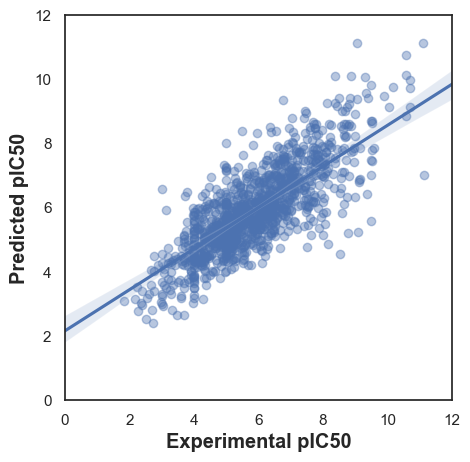

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show

# Prueba adicional

In [90]:
from tensorflow.keras.layers import Dropout

In [241]:
def text_cnn_pa(sequence_length, vocab_size, embedding_size, filter_sizes, num_filters):
    max_pool_div = 4
    input_x = L.Input(shape=(sequence_length,), name='input_x')
    embedding = L.Embedding(vocab_size + 1, embedding_size, name='embedding')(input_x)
    pooled_outputs = []
    for filter_size in filter_sizes:
        conv = L.Conv1D(filters=num_filters, kernel_size=filter_size, padding='same', dilation_rate=1, activation='relu')(embedding)
        max_p = L.MaxPool1D(64)(conv)
        pooled_outputs.append(max_p)

        conv = L.Conv1D(filters=num_filters, kernel_size=filter_size, padding='same', dilation_rate=1, activation='relu')(embedding)
        max_p = L.MaxPool1D(64)(conv)
        pooled_outputs.append(max_p)

        
    h_pool = L.Concatenate(axis=2)(pooled_outputs)
    dense = L.Flatten()(h_pool)
    dense = L.Dense(100, activation='relu')(dense)
    dense = L.Dense(100, activation='relu')(dense)
    dense = L.Dense(1)(dense)
    model = tf.keras.models.Model(input_x, dense)
    return model

In [242]:
FILTER_SIZES = (4,4)
NUM_FILTERS = 128
vocab_size = len(smiles_dict)
embeddings_size =  128

In [243]:
model_pa = text_cnn_pa(max_sequence_len, vocab_size, embeddings_size, FILTER_SIZES, NUM_FILTERS)
model_pa.summary()

Model: "functional_81"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_x (InputLayer)            [(None, 227)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 227, 128)     5504        input_x[0][0]                    
__________________________________________________________________________________________________
conv1d_160 (Conv1D)             (None, 227, 128)     65664       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_161 (Conv1D)             (None, 227, 128)     65664       embedding[0][0]                  
______________________________________________________________________________________

In [227]:
mcp = ModelCheckpoint('models/best_model_pa{epoch}.h5', save_best_only=True,mode="min")
lr_reduce = ReduceLROnPlateau(monitor='loss', 
                                   factor=0.2,
                                   cooldown=0,
                                   patience=5,
                                   min_delta=0.01,
                                   min_lr=1e-5)
ES=EarlyStopping(monitor='val_loss',patience=10, restore_best_weights=True)

In [236]:
model_pa.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=[R2])

In [237]:
history = model_pa.fit(dgen_train, epochs=30, validation_data=dgen_test, callbacks=[mcp, ES,lr_reduce ])

Epoch 1/30
37/37 [==============================] - 37s 998ms/step - loss: 8.5989 - R2: -2.4895 - val_loss: 3.0301 - val_R2: -0.0411
Epoch 2/30
37/37 [==============================] - 37s 987ms/step - loss: 2.4101 - R2: 0.0738 - val_loss: 2.5016 - val_R2: 0.1902
Epoch 3/30
37/37 [==============================] - 37s 988ms/step - loss: 2.1486 - R2: 0.1748 - val_loss: 2.3394 - val_R2: 0.1942
Epoch 4/30
37/37 [==============================] - 37s 992ms/step - loss: 2.0329 - R2: 0.2211 - val_loss: 2.2266 - val_R2: 0.2718
Epoch 5/30
37/37 [==============================] - 37s 994ms/step - loss: 1.9782 - R2: 0.2403 - val_loss: 2.1885 - val_R2: 0.2838
Epoch 6/30
37/37 [==============================] - 37s 991ms/step - loss: 1.8879 - R2: 0.2800 - val_loss: 2.1401 - val_R2: 0.2987
Epoch 7/30
37/37 [==============================] - 37s 993ms/step - loss: 1.7661 - R2: 0.3267 - val_loss: 2.0748 - val_R2: 0.3170
Epoch 8/30
37/37 [==============================] - 37s 992ms/step - loss: 1.7099

In [238]:
X_test_eval = []
y_t_eval = []
for X_t, y_t in dgen_test:
    X_test_eval = X_test_eval + [list(t) for t in X_t]
    y_t_eval = y_t_eval + list(y_t)
X_test_eval = np.array(X_test_eval)
y_test = np.array(y_t_eval)

In [239]:
y_pred = model_pa.predict(X_test_eval)

# Score

In [240]:
r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()
r2

0.37722569135588446